In [1]:
#!/usr/bin/env python
# generic scientific/ipython header
from __future__ import print_function
import os, sys
import pandas as pd
import scipy.stats as stats
import scipy as sci
import numpy as np
import pylab
get_ipython().magic(u'matplotlib inline')

In [2]:
import random as rand

### OpenEye section: load up relevant libs and depiction functions

We will use depictMatch, which highlights the SMARTS matches but not yet the SMIRKS map indices

In [3]:
import openeye.oechem as oechem
import openeye.oedepict as oedepict
from IPython.display import display

In [4]:
def depictMatch(mol, match, width=500, height=200):
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(False)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetTitleLocation(oedepict.OETitleLocation_Bottom)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    hstyle = oedepict.OEHighlightStyle_Color
    hcolor = oechem.OEColor(oechem.OEDarkGreen)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))

In [5]:
def smirksToSubsearch( smirks, chemGroups):
    '''Takes a SMIRKS string and a list of substitution chemical groups and returns the
    corresponding Substructure Search object if the SMIRKS string is well-formed'''
    modSmarts = oechem.OESmartsLexReplace( Smarts, chemGroups)
    if Smarts != modSmarts:
        print("orig     smarts: %s\nmodified smarts: %s" % (Smarts, modSmarts))
    qmol = oechem.OEQMol()
    if not oechem.OEParseSmarts( qmol, modSmarts ):
        print( 'OEParseSmarts on %s failed' % modSmarts )
    return oechem.OESubSearch( qmol)

### Load lib for chemical environments

Note full path to the library over in the smarty git tree

In [6]:
import imp
smirky = imp.load_source('environment','/Users/bayly/BaylyData/collaborations/sabbatical/smarty/smarty/environment.py')

### Chemical groups we might use

In [7]:
chemGroups = [ ('ewg1', '[#7,#8!-1,#16!-1,F,Cl,Br,I]'),
               ('ewg1di', '[#7!X1,#8!X1,#16!X1]') ]

### initialize a torsion with brute force lists for atoms and bonds

In [8]:
#torsionEnv1 = smirky.TorsionChemicalEnvironment([['#6'], ['X4']], [['-'], None], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']])
#torsionEnv1 = smirky.TorsionChemicalEnvironment([['#6'], ['X4']], [['!#', '!@'], None], [['#6'], ['X4']], [None,None], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']])
torsionEnv1 = smirky.TorsionChemicalEnvironment([['#6'], ['X4']], [['!#', '!@'], None], [['#6'], ['X4']], [['-',':','='],['@']], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']])
print( torsionEnv1.asSMIRKS() )

[#6;X4:1]!@,!#[#6;X4:2]=,:,-;@[#6;X4:3]-[#6;X4:4]


### torsions from atom and bond sublists

In [9]:
# Sublists
A_any = [None,None]
A_C = [ ['#6'], None]
A_Ctet = [ ['#6X4'], None]
A_O = [ ['#8'], None]
A_OEth = [ ['#8X2'], ['H0','+0']]
A_OH = [ ['#8X2'], ['H1','+0'] ]
A_H = [ ['H'], None]
Bsngl = [ ['-'], None]
BnoRing = [ ['!@'], None]
B_any = [ None, None]

In [10]:
# specific torsions from sublists
torsionEnv2 = smirky.TorsionChemicalEnvironment( A_Ctet,B_any,A_Ctet,Bsngl,A_OH,B_any,A_any )
torsionEnv3 = smirky.TorsionChemicalEnvironment( A_OEth,B_any,A_Ctet,Bsngl,A_OH,B_any,A_any )
torsionEnv4 = smirky.TorsionChemicalEnvironment( A_OEth,B_any,A_Ctet,Bsngl,A_O,B_any,A_any )
print( torsionEnv4.asSMIRKS() )

[#8X2;H0;+0:1]~[#6X4:2]-[#8:3]~[*:4]


In [11]:
# specific angles from sublists 
angEnv1 = smirky.AngleChemicalEnvironment( A_OEth,B_any,A_Ctet,Bsngl,A_OH)
angEnv2 = smirky.AngleChemicalEnvironment( A_Ctet,B_any,A_Ctet,Bsngl,A_Ctet)
angEnv3 = smirky.AngleChemicalEnvironment( A_Ctet,B_any,A_Ctet,BnoRing,A_Ctet)
print( angEnv3.asSMIRKS() )

[#6X4:1]~[#6X4:2]!@[#6X4:3]


In [12]:
Smarts = torsionEnv4.asSMIRKS()
ss = smirksToSubsearch( Smarts, chemGroups)

In [13]:
fileprefix= 'AlkEthOH_dvrs1'
ifs = oechem.oemolistream(fileprefix+'.oeb')
#ofs = oechem.oemolostream(fileprefix+'_filt1.smi')

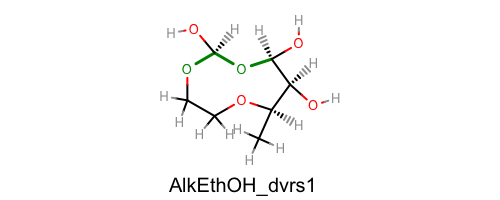

8 5 9 4 
1 2 3 4 

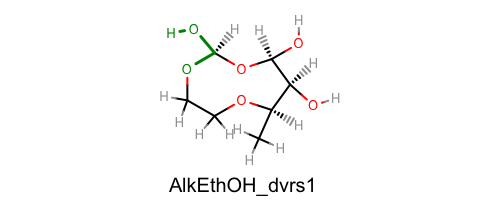

8 5 12 26 
1 2 3 4 

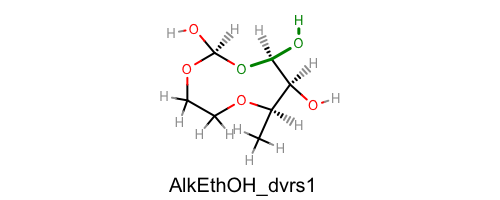

9 4 11 25 
1 2 3 4 

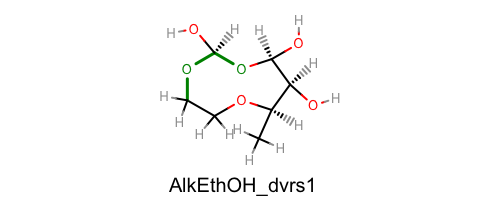

9 5 8 1 
1 2 3 4 

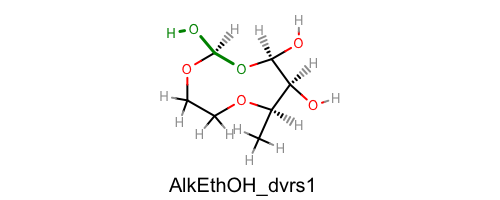

9 5 12 26 
1 2 3 4 

In [14]:
mol = oechem.OEMol()
for mol in ifs.GetOEMols():
    goodMol = True
    oechem.OEPrepareSearch(mol, ss)
    unique = True
    for match in ss.Match(mol, unique):
        display( depictMatch(mol, match))
        for ma in match.GetAtoms():
            print(ma.target.GetIdx(), end=" ")
            #print(ma.pattern.GetIdx(), end=" ")
        print('')
        for ma in match.GetAtoms():
            print(ma.pattern.GetMapIdx(), end=" ")

In [15]:
ifs.close()
#ofs.close()

In [16]:
# Generic move lists (initial guess)
#AtmNums = ['','#1','5','#6','7','#8','9','15','16','17','35','53']
#AtmORdecs = ['', 'X4','X3','X2','X1']
#AtmAndDecs = ['','H0','+0',]
#BondOrdr = ['','-',':','=','#','~']
#BondANDDecs = ['','@','!@','!#']

# AlkEthOH move lists (initial guess)
AtmNums = ['','#1','#6','#8']
AtmORdecs = ['', 'X4','X3','X2','X1']
AtmAndDecs = ['','H0']
BondOrdr = ['','-','~']
BondANDDecs = ['','@','!@']

In [34]:
torsion = torsionEnv4
print( torsion.asSMIRKS() )
print( torsion.atom1.getORtypes() )
print( torsion.atom1.getANDtypes() )
atom1 = torsion.selectAtom( 4)
print('Selected atom : ',atom1.index, atom1.getORtypes(), atom1.getANDtypes() )
atmlist = torsion.getAtoms()
for atom in atmlist:
    print(atom.index, atom.getORtypes(), atom.getANDtypes() )
bond2 = torsion.getBond(torsion.atom2,torsion.atom3)
print( bond2.getORtypes() )
print( bond2.getANDtypes() )

[#8X2;H0;+0:1]~[#6X4:2]-[#8:3]~[*:4]
['#8X2']
['H0', '+0']
Selected atom :  4 [] []
4 [] []
1 ['#8X2'] ['H0', '+0']
3 ['#8'] []
2 ['#6X4'] []
['-']
[]


In [18]:
patternLength= { 'Torsion': 4, 'Improper': 4, 'Angle': 3, 'Bond': 2, 'Vdw': 1}

In [23]:
param = torsionEnv3
print( param.asSMIRKS() )
for i in range(0,20):
    AtmOrBnd = rand.choice( ['atom','atom','bond'])
    if AtmOrBnd=='atom':
        atom = param.selectAtom()
        print( AtmOrBnd, atom.index, atom.getORtypes(), atom.getANDtypes() )
    elif AtmOrBnd=='bond':
        firstAtom, secondAtom, bond = param.selectBond()
        print( AtmOrBnd, firstAtom.index, secondAtom.index, bond.getORtypes(), bond.getANDtypes() )
    else:
        raise ValueError ('expected string to be either "atom" or "bond"')

[#8X2;H0;+0:1]~[#6X4:2]-[#8X2;H1;+0:3]~[*:4]
atom 4 [] []
atom 4 [] []
bond 3 4 [] []
atom 2 ['#6X4'] []
bond 3 2 ['-'] []
atom 1 ['#8X2'] ['H0', '+0']
atom 2 ['#6X4'] []
atom 1 ['#8X2'] ['H0', '+0']
atom 4 [] []
bond 1 2 [] []
atom 4 [] []
atom 4 [] []
atom 4 [] []
atom 3 ['#8X2'] ['H1', '+0']
atom 1 ['#8X2'] ['H0', '+0']
atom 3 ['#8X2'] ['H1', '+0']
bond 1 2 [] []
bond 1 2 [] []
bond 2 1 [] []
atom 3 ['#8X2'] ['H1', '+0']


In [37]:
print( param.asSMIRKS() )
atom = param.selectAtom()
print( 'atom:', atom.index, atom.getORtypes(), atom.getANDtypes() )
firstAtom, secondAtom, bond = param.selectBond()
print( 'bond:', firstAtom.index, secondAtom.index, bond.getORtypes(), bond.getANDtypes() )

[#8X2;H0;+0:1]~[#6X4:2]-[#8X2;H1;+0:3]~[*:4]
atom: 4 [] []
bond: 4 3 [] []


In [36]:
atomFeatures = ['AtNum', 'ORdec', 'ANDdec']
bondFeatures = ['ORtype', 'ANDtype']
actionChoices = ['add','swap','delete']

In [63]:
# parse atom ORtypes into atomic elements (AtNums) and decorators (Ordecs)
print( param.asSMIRKS() )
atomORtypes = atom.getORtypes()
print( atomORtypes)
atomORtypes = [rand.choice(AtmNums)]
print( atomORtypes)
atom.setORtypes( atomORtypes)
print( param.asSMIRKS() )

[#8X2;H0;+0:1]~[#6X4:2]-[#8X2;H1;+0:3]~[#1:4]
['#1']
['']
[#8X2;H0;+0:1]~[#6X4:2]-[#8X2;H1;+0:3]~[:4]


In [51]:
for i in range(0,20):
    print( rand.choice( atomFeatures), rand.choice( actionChoices) )

AtNum add
ANDdec add
ORdec swap
AtNum delete
ANDdec add
ANDdec delete
ANDdec add
ANDdec delete
ANDdec add
ANDdec delete
ORdec add
AtNum swap
ANDdec swap
AtNum swap
ORdec add
ANDdec add
AtNum swap
AtNum add
ORdec delete
ANDdec add


In [52]:
help( atom.setORtypes)

Help on method setORtypes in module environment:

setORtypes(self, newORtypes) method of environment.Atom instance
    sets new ORtypes for this atom
    
    Parameters
    ----------
    newORtypes: set of strings
        strings that will be OR'd together in a SMARTS

